# MATE50001 Coding Project

Group Members: Annabel Hoyes, Clotilde Offner, James Ormsby, Sophia Reid, Romain Santeiu

## Project Structure
Our code can be broken down into four sections: combining data from separate countries into a single dataset, 3-step pre-processing, classification, and visualisation. The first code cell imports all the required modules for the project, and the last code cell actually starts and runs the code defined in the other cells. Therefore for the code to run correctly, it is required to run all code cells, in the order that they are presented.

In [19]:
from sklearn import model_selection, impute, svm
from matplotlib.widgets import Button, CheckButtons, RadioButtons
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import json

# List of elements used in the data
elements = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

# List of colors for each element in the graph
element_colors = ["blue", "green", "red", "yellow",
                  "gray", "purple", "cyan", "magenta", "orange"]

# Verbosity for console output
# 1 - Only classifier score and final classification will be printed
# 2 - All from above + number of data points, each classifier fold and time
# 3 - All from above + most dataframes used, and much more detailed classifier info
# Recommended to leave on 2
verbosity = 2

## Combining data
For our model, data from glass databases from the US, UK and EU were used. Each country collected data in different data types (.csv and .json) and used different standards to measure the data. As such, the data from each country was converted into a pandas DataFrame and then all combined to create one, larger, combined dataset. Unnecessary data, such as Date, UUID, Supervisor, Initials, State, and Unnamed: 0, were removed, or ‘dropped’ from the dataset to keep the code short and concise. This was done at the end of the code, once it had been combined, as opposed to doing it to each individual dataset.

The data from the US was particularly difficult, as the data were floats in .json files that were grouped by department. To accommodate for this, the code converts them into integers, groups them together and then converts them into a pandas DataFrame.

In [20]:
def load_data():
    """Loads data from the various database files

    Returns:
        Dataframe containing all the important data used in the classifier
    """
    # Converting the different data types from the different countries into dataframes

    # Converting the UK data from CSV file to dataframe
    raw_data_uk = pd.read_csv('./glass_uk.csv')
    raw_data_uk_df = pd.DataFrame(raw_data_uk)

    # Converting the EU data from JSON file to dataframe
    with open('./glass_eu.json') as f:
        raw_data_eu = json.load(f)
        raw_data_eu_df = (pd.DataFrame(raw_data_eu))
        raw_data_eu_df = raw_data_eu_df.transpose()

    # Converting the US data from JSON file to dataframe
    with open('./glass_us.json') as f:
        raw_data_us = json.load(f)

    # The US data is grouped by department, so the department data is combined and then converted from floats to integers
    raw_data_us.keys()
    raw_data_us_FBI = pd.DataFrame(raw_data_us['FBI'])
    raw_data_us_NYPD = pd.DataFrame(raw_data_us['NYPD'])
    raw_data_us_CIA = pd.DataFrame(raw_data_us['CIA'])
    raw_data_us_USN = pd.DataFrame(raw_data_us['USN'])
    raw_data_us_df = pd.concat((raw_data_us_FBI, raw_data_us_NYPD,
                               raw_data_us_CIA, raw_data_us_USN)).reset_index(drop=True)
    raw_data_us_df['Type'] = raw_data_us_df['Type'].astype(int)

    # Combining all the dataframes
    df_concat = pd.concat((raw_data_uk_df, raw_data_eu_df,
                          raw_data_us_df)).reset_index(drop=True)

    # Drop columns 'Unnamed: 0', Supervisor', 'Initials', 'State', 'UUID' and 'Data Collected' as unnecessary for the model
    df_concat = df_concat.drop(
        columns=['Unnamed: 0', 'Supervisor', 'Initials', 'State', 'UUID', 'Date Collected'])

    elements_dict = df_concat[elements]
    # Sum each row
    elements_dict.sum(axis=1)
    # Add sums as new column to dataset
    df_concat['Total Composition'] = elements_dict.sum(axis=1)

    # Print out some info on the data
    if (verbosity > 1):
        print(df_concat.count())
        print(df_concat.where(lambda x: x != 0).count())
        print(df_concat["Total Composition"].where(lambda x: x >= 90).count())

    return df_concat

def load_samples():
    """Load the samples from the file"""

    return pd.read_table("./samples.evidence", sep=' ')

## 3 steps pre-processing:

### 1)	IQR: 
The first step of pre-processing was to handle outliers in the combined data set. It was crucial to remove outliers as it increased the accuracy of the dataset. Therefore the training process of the machine learning algorithm and the statistical analysis were not negatively affected by these outliers. 

After calculating the Interquartile range (IQR), upper and lower bounds of the data set were found by adding or subtracting the product of the IQR and a standard value, 1.5, with the 75th and 25th percentile of the data respectively. Data points outside these bounds were classified as outliers and converted to NaN values. 

### 2)	Scaling:
The data variables having heterogeneous quantities, such as for RI and elemental compositions, feature scaling was thus carried out as the next step of pre-processing. Scaling changes the size but not the shape of the data and brings the values close to a normal distribution allowing it to work best with a Machine Learning algorithm.

The two possible ways of scaling the data were narrowed down to standardisation and min-max scaling, whereby the data was scaled to have a standard deviation of 1 and a mean of 0 or scaled between a specific range of 0 and 1, respectively. A function to input either scaling option was coded. After having run the classifier with both scaling options individually, min-max scaling was deemed to be the most adequate out of the two as it gave the most accurate results.

### 3)	Imputing: 
For the dataset to be complete and in the correct form to be inputted into the classifier in later steps, missing (NaN) values were then imputed.

The missing values in the dataset were replaced using a KNN Imputer from the scikit-learn library that implements the k-Nearest Neighbours algorithm. The imputer returned ‘n’ nearest neighbours and replaced each missing value with the mean of the values of its nearest neighbours. After running this imputer on the dataset multiple times while varying number of nearest neighbours each time, it was found that having 3 nearest neighbours gave us the most accurate results. 

Although replacing NaN values with the mean would have been the simplest solution, it would have reduced variance of the data and introduced a bias into the model. Hence using an alternative to mean imputation based on algorithms used for machine learning was concluded to be best.

In [21]:
def scaler(data: pd.DataFrame, kind='minmax') -> pd.DataFrame:
    """Scales data in the dataframe

    Args:
        data: data to scale
        kind: minmax or standard, type of scaler to use

    Returns:
        Scaled data
    """

    # Ensure the kind is either minmax or standard, the desired input has already been specificed
    assert kind in ['minmax', 'standard']

    # Minmax
    if kind == 'minmax':
        min_value = data.min()          # Finding min. value
        max_value = data.max()          # Finding max. value
        diff = max_value - min_value
        new = data.where(data == 0, (data - min_value) / diff)

    # Standard
    else:
        mean = data.mean(skipna=True, numeric_only=True)
        std = data.std(skipna=True, numeric_only=True)
        new = (data - mean) / std

    return new


def preprocess_data(data):
    """Preprocesses data for use in the classifer

    Args:
        data: data to preprocess

    Returns:
        preprocessed dataframe
    """

    type_dicts = {}
    iqr = pd.DataFrame()

    # Iterate over each type number and add the rows with type i to specific type[i] dict
    for i in range(1, 8):

        # Appending the data and putting into type_dicts
        type_i = data[data['Type'] == i]
        type_dicts[i] = type_i.to_dict()

        # Convert the type dictionaries to dataframes
        type_dicts[i] = pd.DataFrame(type_dicts[i])

        # Calculating interquartile range (IQR)
        iqr_data = type_dicts[i][elements].copy()

        q1 = iqr_data.quantile(0.25)     # Finding lower quartile
        q3 = iqr_data.quantile(0.75)    # Finding upper quartile
        iqr[i] = q3 - q1
        iqr[i] = pd.DataFrame(iqr[i])

        # Finding upper and lower bounds of dataset and removing outliers
        # Outliers are considered to be points outside the bounds

        lower_bound = q1 - 1.5 * iqr[i]
        upper_bound = q3 + 1.5 * iqr[i]

        # Converting values outside the upper and lower bounds to NaN

        iqr_data[(iqr_data < lower_bound) | (iqr_data > upper_bound)] = np.nan
        type_dicts[i][elements] = iqr_data

        # Scaling data in terms of type
        scaled_data = type_dicts[i][elements].copy()
        scaled_type = scaler(scaled_data, kind='minmax')
        type_dicts[i][elements] = scaled_type

    # Combining all standard scaled data into a single dataframe
    processed_data = pd.concat(type_dicts, ignore_index=True)
    processed_data[elements] = scaler(
        processed_data[elements], kind='minmax')

    # Impute the data to remove NaNs
    processed_data[elements] = impute.KNNImputer(n_neighbors=3).fit_transform(
        processed_data[elements], processed_data['Type'])

    return processed_data


## Classification & choice of parameters:
For the classification of the dataset, a Support Vector Mechanism (SVM) machine learning model was used. The aim was to test the data in the most effective way possible, and SVM can handle high dimensional input space which was a particularly crucial factor in choosing this classifier. Furthermore, SVM has a high accuracy as the model is not affected by outliers and the regularisation parameters used avoid overfitting and bias problems. 

The optimal parameters were found for the SVM using the hyperparameter tuning method of grid search from the scikit learn library. This allowed us to test a wide variety of parameters to deduce which combination scores the highest, which these scores were visualised in the resulting graphs. The hyperparameters used were RBF or linear kernel and a C parameter, which varied exponentially.

Furthermore, the stratified k-fold algorithm was used to split up the data equally into the testing and training sets. It also keeps relative proportions of the splitting of the data even though the number of values in each class of the data is imbalanced.

A KNN classifier is best for a small, labelled dataset with minimal noise, therefore as the dataset had the types as labels and was not a large dataset, KNN was trialled. The k-nearest neighbour value, k, was found by finding the Euclidean distance. However, when optimising the parameters, the k obtained was 1, which was too low. This indicates that there was too much noise in the dataset, hence the model overfitted the data and gave a skewed result. This suggested that this model is not reliable and not suitable for our dataset.

After fitting the SVM model to the data, it was shown to have the best results without overfitting the data too much. However, it still overfitted the data slightly as there were not enough data points due to the limited data available. On the positive side, SVM allowed for greater hyper parameter optimisation via grid search.

Additionally, an F1 score was calculated to assess the quality of the model for each element. The F1 score compared to the simpler alternative accuracy score, which tells us how many are right compared to wrong, goes further and considers false positives where data is unbalanced making it a more useful way of measuring the model’s accuracy.

Other Machine Learning algorithms such as random forest was not used as it would have also overfitted the data as it was limited and high dimensional. Logistic regression is only used for binary datasets, so did not apply to the type of data provided in this dataset.

The data was scored on a separate test set using the highest performing classifier found in the grid search, represented by the dashed blue line. On average, we found that with all elements included in the training and testing data, the classifier has an f1 score of around 0.6, or 60%. The variance in this score is very high between each run of the code, indicating that the classifier is very sensitive to which data is used for testing and training. This is due to the very limited number of data points available, hence if more data was available, the classifier would have a better score and significantly less variance between runs.


In [22]:
class Classifier():
    """Classifier class

    Most of the functionality from this class is based on the GridSearchCV class from sklearn
    """

    def __init__(self, *args, **kwargs):
        """Empty constructor"""
        pass

    def _trainOnce(self, data: np.array, labels: np.array, train_fraction: float = 0.8):
        """[DEPRECATED] Train the data once"""

        # Check that the data and labels are the same length
        assert (len(data) == len(labels))

        # Calculate number of rows in each data set, and split accordingly
        n_train_rows = int(len(data) * train_fraction)
        train_data = data[:n_train_rows]
        train_labels = labels[:n_train_rows]
        test_data = data[n_train_rows:]
        test_labels = labels[n_train_rows:]

        # Train and test
        self.classifier.fit(train_data, train_labels)
        return self.classifier.score(test_data, test_labels)

    def _trainOneEpoch(self, data: np.array, labels: np.array, n_splits: int = 4, test_fraction: float = 0.75):
        """[DEPRECATED] Trains the model on one epoch (one complete data set)

        Uses Stratified K Folding to split the data

        Args:
            data (np.array): Data to be trained on (X)
            labels (np.array): Labels for the data (y)
            n_splits (int, optional): How many splits / folds to perform. Defaults to 5
            test_fraction (float, optional): How much of the data set should be used for testing every round. Defaults to 0.8.
        """

        # Check data and labels have same lengths
        assert (data.shape[0] == labels.shape[0])

        # Mix and split the data using shuffled stratified K splitting
        splitter = model_selection.StratifiedShuffleSplit(
            n_splits=n_splits, test_size=test_fraction)

        print(model_selection.cross_validate(
            self.classifier, data, labels, cv=splitter))

    def _optimizeParameters(self, data: np.array, labels: np.array):
        """Trains the model for each hyperparameter combination

        Args:
            data (np.array): Data to be trained on (X)
            labels (np.array): Labels / classes for the data (y)
        """

        # Check data and labels have same lengths
        assert (data.shape[0] == labels.shape[0])

        # Get a train/test split for scoring the model later
        # We dont want to test on data that the model was trained on, as otherwise it would overperform
        train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
            data, labels, test_size=0.2)

        # Create a stratified shuffle splitter
        # This splits up the data 5 times into a training and validation set
        # The splits are done randomly, but trying to keep the same proportions of each class
        splitter = model_selection.StratifiedShuffleSplit(
            n_splits=5, test_size=0.2)

        """The functions below perform the grid search 

        It contains the model parameter, the grid of variables to be optimised,
        and a couple other parameters.
        """
        # Perform the grid search for SVM
        self.grid_search = model_selection.GridSearchCV(
            svm.SVC(), param_grid=[
                {"kernel": ["rbf"], "gamma": [1e-4],
                    "C": np.logspace(1, 4, 7)},
                {"kernel": ["linear"], "C": np.logspace(1, 4, 7)},
            ], scoring="f1_weighted", cv=splitter, verbose=verbosity, n_jobs=-1)

        # Perform the grid search for KNN
        # self.grid_search = model_selection.GridSearchCV(
        #     KNeighborsClassifier(), param_grid={"n_neighbors": range(1, 20, 2)}, scoring="f1_weighted", cv=splitter)

        # Perform the grid search for MLP
        # self.grid_search = model_selection.GridSearchCV(
        #     neural_network.MLPClassifier(max_iter=3000), param_grid={
        #         # 'activation': ['logistic', 'tanh', 'relu'],
        #         # 'solver': ['lbfgs', 'sgd', 'adam'],
        #         'hidden_layer_sizes': [(i, ) for i in range(5, 10)]
        #     }, scoring="f1_weighted", n_jobs=-1)

        # Actually fit the grid search to the data
        self.grid_search.fit(train_data, train_labels)
        if (verbosity > 2):
            print(self.grid_search.cv_results_)

        # Score with the leftover training set, and return the score and results
        return (self.grid_search.score(test_data, test_labels), self.grid_search.cv_results_)

    # Train the classifier
    def train(self, data: np.array, labels: np.array):
        return self._optimizeParameters(data, labels)

    # Predict using the classifier
    def predict(self, data: np.array):
        return self.grid_search.predict(data)


## Visualisation 

### 1)	Visualising stages of pre-processing
For the graph, a 2D plot including N and Composition, the two variables in play, as the x,y values was included. We knew it would be impossible to display the data on each individual element axes therefore decided to use a Composition axis to display each element at once. This was also useful as it allows us to view the data relative to the rest which is useful for comparison and analysis. It also allows the user to rotate and zoom into each part of the graph. 

This was helpful as it allows the user to analyse and read the data focusing on certain points if they want to. In the end it was decided the RI variable would simply be treated as an element and the graph would hence no longer be a 3D plot.

To add the feature of being able to select which element and type the graph displays we used two individual sets of check buttons, these allowed selection of displaying elemental composition as well as type. For example if you wanted only the ‘Na’ values which are Type 6 then you would select the Na box and the Type 6 box. These checkboxes contained functions which read the labels and located the data with the same labels. This allowed us to compare the types to each other as well as view individual elements. 

In order to view the pre-processing route taken, Radio Buttons were added allowing the user to switch between the Initial, Imputed and Processed data. Therefore, you can see how the data has been processed through a 2D graphical Visualisation. Due to the different datasets being inputted in the graphs, the axes had to be scaled each time specifically to each dataset. This made the graph automatically adjust therefore showing the complete range of data in each dataset.

### 2)	Visualising classifier output
The second visualisation graph shows a bar chart including the relative classifier parameter scores, between 0 and 1 (1 being perfect accuracy) based on F1 score, on the y axis and the different Machine Learning parameters on the x axis. 

When the data is initially inputted, it includes all the elemental composition data when running the Machine Learning algorithm, therefore we wanted to be able to compare what happens when the elemental composition data is restricted.  In order to do this, check boxes were added and instantly set to active (due to all the elemental data initially being included). When switched off the classifier re-runs and re-fits without considering the selected elemental composition data in the Machine Learning algorithm. This will alter the F1_scores for each Machine Learning parameter on the x axes showing different values and therefore giving a comparison of how good each parameter is based on the included data.


In [23]:
class Graphs:
    """Creates interactive graphs for user"""

    files = {
        "Combined": "./data/combined_data.csv",
        "Processed": "./data/processed_data.csv",
        "Evidence":  "./data/evidence_data.csv"
    }

    def __init__(self):
        """Constructor for the graph class

        This creates the containers for the graphs, sets up the 
        buttons and callbacks.
        To actually render the graphs, call plt.ion() and plt.show()
        """

        self.fig = plt.figure(layout='constrained', figsize=(
            12, 6))        # Initalizes figure

        # Add and label axis
        buttons, elem_graph, perf_histogram = self.fig.subfigures(
            1, 3, wspace=0.05, width_ratios=[0.25, 1, 0.75])

        # Add the composition subplot
        self.ax = elem_graph.add_subplot()
        self.ax.set_xlabel('N')
        self.ax.set_ylabel('Composition')

        # Add the histogram subplot
        self.hist = perf_histogram.add_subplot()
        self.hist.set_xlabel('Parameters')
        self.hist.set_ylabel('f1 score')
        self.hist.set_ylim(0, 1)

        # Read the file to get initial data
        self.data = pd.read_csv(self.files["Processed"])
        self.scatter_plots = {}

        # Creates check boxes
        check_ax = buttons.add_axes(
            [0.0, 0.45, 1, 0.3],
            facecolor='royalblue'
        )
        check_ax_type = buttons.add_axes(
            [0.0, 0.1, 1, 0.3],
            facecolor='royalblue'
        )

        # Creates radio boxes
        radio_ax = buttons.add_axes(
            [0.0, 0.8, 1, 0.2],
            facecolor='royalblue'
        )

        # Create the buttons and link to the callbacks
        self.element_check = CheckButtons(
            check_ax,
            [e for e in elements],
            [True for e in elements]
        )
        self.element_check.on_clicked(
            lambda *args: self.on_elements_change(*args))

        self.type_check = CheckButtons(
            check_ax_type,
            [i for i in range(1, 8)],
            [True for i in range(1, 8)]
        )
        self.type_check.on_clicked(lambda *args: self.redraw())

        self.file_select = RadioButtons(
            radio_ax,
            [label for _, label in enumerate(self.files)],
        )
        self.file_select.set_active(1)
        self.file_select.on_clicked(lambda *args: self.reload_file())


        # Format the button windows
        for c in self.element_check.rectangles:
            c.set_facecolor('white')
        for c in self.type_check.rectangles:
            c.set_facecolor('white')

        check_ax.set_title("Elemental Composition:", fontsize=8,
                           fontweight='bold', family='serif')
        for label in self.element_check.labels:
            label.set_color('white')
        check_ax_type.set_title("Type:", fontsize=8,
                                fontweight='bold', family='serif')
        for label in self.type_check.labels:
            label.set_color('white')
        for i, label in enumerate(self.file_select.labels):
            label.set_color('white')

        # Force a redraw to actually put stuff on the graph
        self.redraw()

    def reload_file(self):
        """Reloads the file based on the currently selected option"""
        self.data = pd.read_csv(self.files[self.file_select.value_selected])
        self.redraw() # Force a redraw as the data has changed

    def redraw(self):
        """Redraws the graph with the currently selected options"""

        # Clear old plots
        self.ax.clear()
        self.ax.set_xlabel('N')
        self.ax.set_ylabel('Composition')

        # Rescale scatter plot to file
        self.ax.set_ylim(
            self.data[elements].min().min(), self.data[elements].max().max())
        self.ax.set_xlim(0, 205)

        # Only plot data of the correct type
        data_to_plot = self.data[self.data['Type'].isin([
            i + 1 for i, x in enumerate(self.type_check.get_status()) if x])]

        # Locates data with specifc type and periodic element from FullArray
        x = data_to_plot.loc[:, 'N']

        # For each element class
        for elementToPlot in [elements[i] for i, e in enumerate(self.element_check.get_status()) if e]:

            # Create a new scatter plot, with the correct color and size
            scatter = self.ax.scatter(x, data_to_plot[elementToPlot], c=[
                                      element_colors[elements.index(elementToPlot)] for l in range(len(data_to_plot))],
                                      s=[7 for i in range(len(data_to_plot))])

            # Keep a reference to the scatter plot otherwise it gets GCed
            self.scatter_plots[elementToPlot] = scatter

        # Redraw graph
        self.fig.canvas.draw_idle()

    def draw_perf_data(self, score, perf_data):
        """Draw the initial performance data of the classifier

        Args:
            score: final classifer score, will be drawn as a dashed line
            perf_data: Performance data from the classifier
        """

        # Save these for later redrawing
        self.init_score = score
        self.init_perf = perf_data

        # Get the x and y for the bar plots
        x = [i for i in range(len(perf_data["params"]))]
        y = [i for i in perf_data["mean_test_score"]]

        # Draw the bar plots and line on the graph
        self.hist.axhline(
            y=score, color='blue', linestyle="--", label=score)
        bar = self.hist.bar(x, y, width=0.4, color="blue")

        # Label the bars
        self.hist.bar_label(
            bar, [f"Kernel: {label['kernel']}, C: {round(label['C'], 2)}" for label in perf_data["params"]], rotation="vertical")

    def draw_new_perf_data(self, score, perf_data):
        """Draw the new performance data of the classifier

        Args:
            score: new classifier score,
            perf_data: new performance data
        """

        # Clear and reset the graph
        self.hist.clear()
        self.hist.set_xlabel('Parameters')
        self.hist.set_ylabel('f1 score')
        self.hist.set_ylim(0, 1)

        # Draw the initial data again
        self.draw_perf_data(self.init_score, self.init_perf)

        # Draw the new data in orange
        x = [i + 0.4 for i in range(len(perf_data["params"]))]
        y = [i for i in perf_data["mean_test_score"]]
        self.new_perf = self.hist.bar(x, y, width=0.4, color="orange")
        self.new_perf_line = self.hist.axhline(
            y=score, color='orange', linestyle="--", label=score)

    def register_elements_callback(self, func):
        """Register a callback for when an element is selected/deselected

        Args:
            func: callback to call when element selection is changed
        """

        self.elements_callback = func

    def on_elements_change(self, *args):
        """Called whenever elements are changed"""

        # Call the registerd callback, with the currently selected elements as a first param
        self.elements_callback([elements[i] for i, e in enumerate(
            self.element_check.get_status()) if e], *args)

        # Redraw the graph
        self.redraw()


RI                   181
Na                   193
Mg                   181
Al                   192
Si                   191
K                    194
Ca                   183
Ba                   185
Fe                   187
Type                 206
Total Composition    206
dtype: int64
RI                   160
Na                   167
Mg                   128
Al                   169
Si                   175
K                    147
Ca                   164
Ba                    29
Fe                    55
Type                 206
Total Composition    206
dtype: int64
134
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Classifier Score: 0.6073948097757622
[1 2 1 6 7 1 6 7]


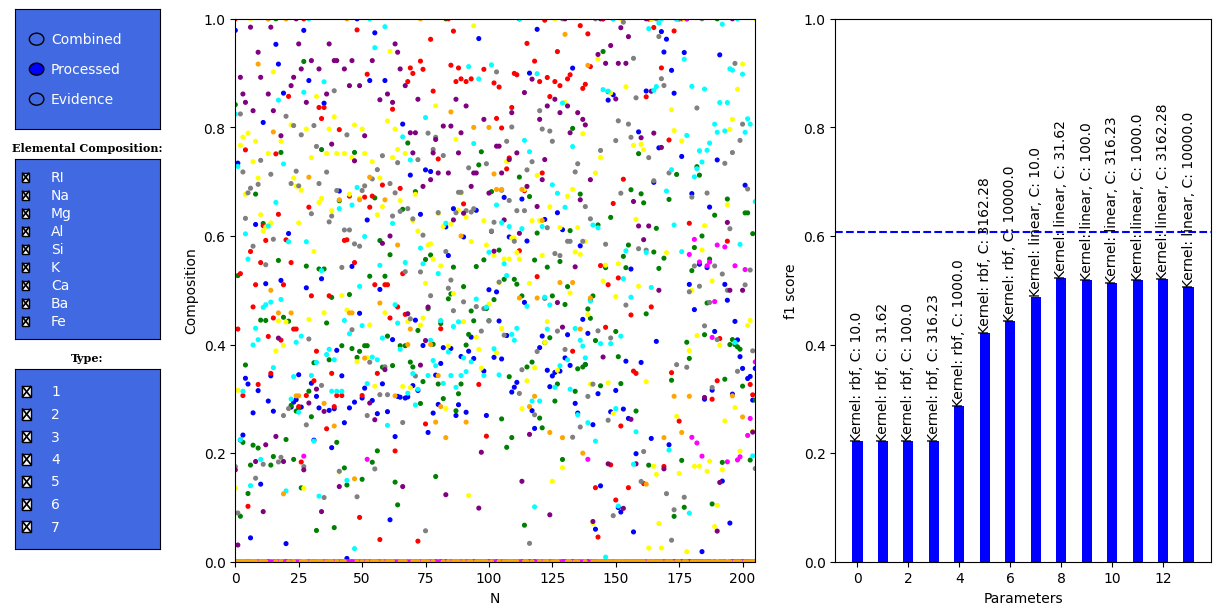

In [24]:
# Load and combine the data into one dataframe
combined_df = load_data()
combined_df.to_csv('./data/combined_data.csv', index_label='N')
if verbosity > 2:
    print(combined_df)

# Preprocess the data
processed_df = preprocess_data(combined_df)
processed_df.to_csv('./data/processed_data.csv', index_label='N')
if verbosity > 2:
    print(processed_df)

# Split the data into the features and labels
data = np.array(processed_df[elements])
labels = np.array(processed_df['Type'].astype(int))

# Train the classifier
classifier = Classifier('SVM')
score, perf_data = classifier.train(data, labels)
print(f"Classifier Score: {score}")

# Init and draw the graphs
graph = Graphs()
graph.draw_perf_data(score, perf_data)

# Set up the callback to retrain the classifier when the element selection is changed


def on_element_change(new_elem_list, *args):
    new_score, new_perf_data = classifier.train(
        np.array(processed_df[new_elem_list]), processed_df['Type'].astype(int))
    graph.draw_new_perf_data(new_score, new_perf_data)


graph.register_elements_callback(on_element_change)

# Load the evidence data
evidence_data = scaler(load_samples(), kind='standard')
evidence_data.to_csv('./data/evidence_data.csv', index_label='N')
if (verbosity > 2):
    print(evidence_data)

# Print the predictions of the classifer on the evidence data
print(classifier.predict(np.array(evidence_data[elements])))

# Show the plot and make it interactive
plt.show()
plt.ion()

## Conclusion

The results of the classifier vary between each run. The lack of consistent results is due to the very low amount of data provided. When all elements are selected, the classifier has an average F1 score of 0.6, or 60%. When using the classifier to predict the type of glass for each of the evidence samples, the results varied between runs. However, no glass from the evidence file was classified as type 3. This indicates that none of the glass samples are vehicle windows that are float processed, so this piece of evidence alone would exonerate the criminals. Due to the low accuracy of the classifier, and the lack of consistent results due to the very low amount of data provided, other evidence should be gathered and analyzed before a final decision is made.